In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from src.cstr import *
from src.machinelearning import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [100]:
df = generate_training_data(samples=10000, return_df=True)
X = df[['w1', 'Cb']].values
y = df['Cb_next'].values

100%|██████████| 10000/10000 [00:00<00:00, 259606.35it/s]


In [101]:
input_dim = X.shape[1]
output_dim = 1

model = NeuralNet(input_dim,output_dim).to(device)
model = train_nn(model, X, y, 20000)

Epoch [1000/20000], Loss: 0.1217
Epoch [2000/20000], Loss: 0.0848
Epoch [3000/20000], Loss: 0.0714
Epoch [4000/20000], Loss: 0.0265
Epoch [5000/20000], Loss: 0.0125
Epoch [6000/20000], Loss: 0.0102
Epoch [7000/20000], Loss: 0.0092
Epoch [8000/20000], Loss: 0.0084
Epoch [9000/20000], Loss: 0.0078
Epoch [10000/20000], Loss: 0.0072
Epoch [11000/20000], Loss: 0.0069
Epoch [12000/20000], Loss: 0.0068
Epoch [13000/20000], Loss: 0.0065
Epoch [14000/20000], Loss: 0.0064
Epoch [15000/20000], Loss: 0.0063
Epoch [16000/20000], Loss: 0.0061
Epoch [17000/20000], Loss: 0.0060
Epoch [18000/20000], Loss: 0.0058
Epoch [19000/20000], Loss: 0.0057
Epoch [20000/20000], Loss: 0.0055


In [102]:
Cb_ref = np.array([20.9 if t < 20 else 21.0 if t < 40 else 20.5 for t in range(L)])

Cb_res, w1_res = simulation(model, Cb_ref)

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:02<00:00, 24.17it/s]


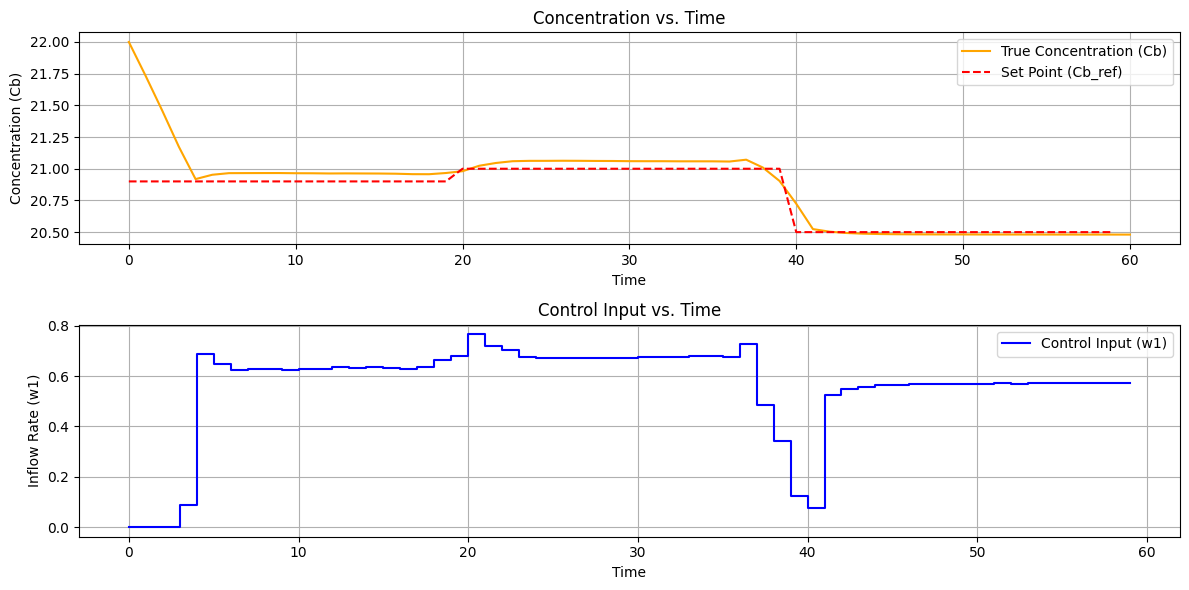

In [103]:
plot_results(Cb_res, Cb_ref, w1_res)

#### Evaluation of optimal `w1` using the real system dynamics

In [104]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d

# --- Real System Dynamics --- #
def system_of_odes(t, y, w2):
    h, Cb = y
    w1 = w1_func(t)  # Get w1 at time t using interpolation
    dh_dt = w1 + w2 - 0.2 * np.sqrt(h)
    dCb_dt = ((Cb1 - Cb) * w1 / h + (Cb2 - Cb) * w2 / h - k1 * Cb / (1 + k2 * Cb)**2)
    return [dh_dt, dCb_dt]

# Make negative w1_res zero
t_points = np.arange(0, L, dt)  
w1_func = interp1d(t_points, w1_res, kind='linear', fill_value="extrapolate")

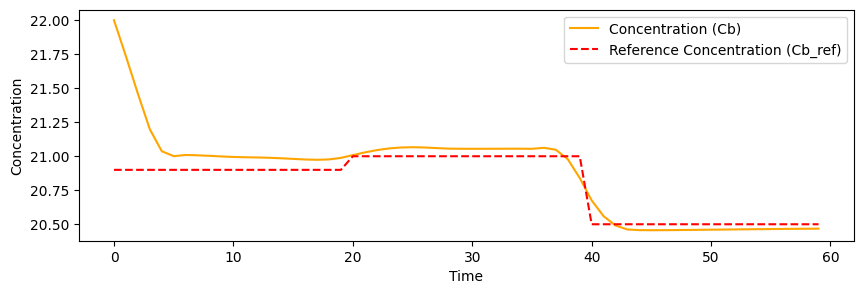

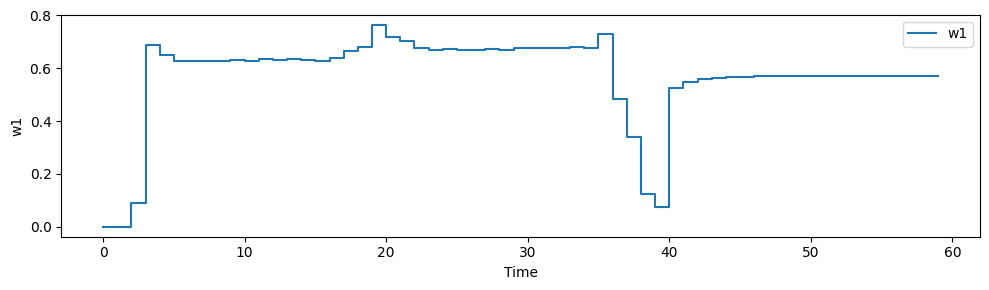

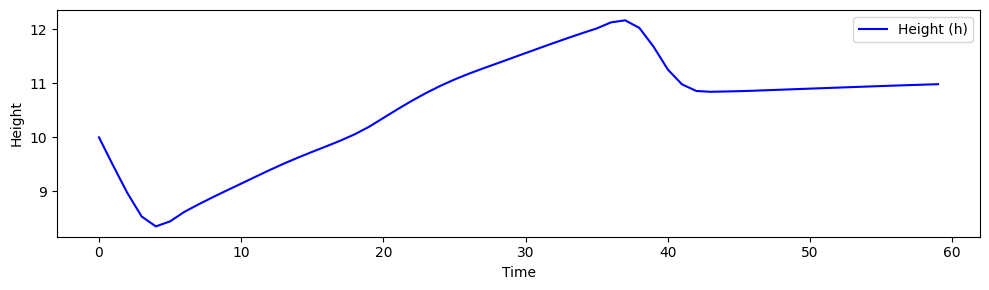

In [105]:
# Time span for the solution
t_span = (0, L)  # From t=0 to t=L
y0 = [h0, Cb0]  # Initial
sol = solve_ivp(system_of_odes, t_span, y0, args=(w2,), 
                method='RK45', t_eval=np.arange(0, L, dt))

# Extract the solution
t = sol.t
h = sol.y[0]
Cb = sol.y[1]

# Plot the results
plt.figure(figsize=(10, 3))
plt.plot(t, Cb, label='Concentration (Cb)', color='orange')
plt.plot(t, Cb_ref, label='Reference Concentration (Cb_ref)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

# Plot the input w1
plt.figure(figsize=(10, 3))
plt.step(t, w1_func(t), label='w1')
plt.xlabel('Time')
plt.ylabel('w1')    
plt.legend()

plt.tight_layout()
plt.show()

# Plot h 
plt.figure(figsize=(10, 3))
plt.plot(t, h, label='Height (h)', color='blue')
plt.xlabel('Time')
plt.ylabel('Height')
plt.legend()
plt.tight_layout()
plt.show()

In [106]:
results_df = pd.DataFrame()
results_df['MPC'] = Cb_res[:-1]
results_df['Real'] = Cb
results_df['Diff'] = np.abs(results_df['MPC'] - results_df['Real'])
results_df

,MPC,Real,Diff
0,22.000000,22.000000,0.000000
1,21.734571,21.734458,0.000113
2,21.459090,21.459674,0.000584
3,21.172980,21.198353,0.025372
4,20.918298,21.037192,0.118893
5,20.952482,21.000526,0.048043
6,20.965191,21.009373,0.044181
7,20.965622,21.006914,0.041292
8,20.965922,21.003015,0.037093
9,20.966027,20.998540,0.032513


In [107]:
results_df.mean()

MPC     20.875918
Real    20.877167
Diff     0.020560
dtype: float64